# Cohort 400 AUCs analysis

### Imports and environment setup

- Date of run: 2024-08-20
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Utils imports
import cohort_analysis_utils as utils
import ms_utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

# Data loading and preprosessing

For this analysis, we are going to work with the MS ratios file ─located at ["data/ms/Womec_targetedDIA_ratio.csv"](<../data/ms/Womec_targetedDIA_ratio.csv>)─. In the same folders there are files for MS areas, untargeted MS, metadata from the patients and protein data.

In [4]:
METADATA_PATH = '../data/ms/Womec_DIA_patients.csv'
WOMEC_DIA_PATH = '../data/ms/Womec_targetedDIA_ratio.csv'
PROTEIN_DATA_PATH = '../data/ms/Womec_DIA_protein_data.csv'

# Key field to link the metadata with the WOMEC data
KEY_COLUMN = 'filename_womec'


In [5]:
# Load, harmonize and merge the data with the metadata
df_400 = ms_utils.load_data_with_metadata(WOMEC_DIA_PATH, METADATA_PATH, KEY_COLUMN)

In [6]:
# Different peptides for the same protein will have the same column name, rename then as _0, _1, _2, etc.
df_400 = ms_utils.rename_duplicated_columns(df_400)

In [7]:
# Ensure categorical columns are treated as such
df_400 = utils.cols_as_category(df_400, {'Condition':{'Benigna': 0, 'EC': 1, 'Sarcoma uterino': 1}})

In [8]:
# Define the biomarkers columns
BIOMARKERS_400 = list(df_400.columns[17:])

In [9]:
# Ensure numerical columns are treated as such
df_400 = utils.cols_as_numbers(df_400, BIOMARKERS_400)

In [10]:
# We load in a separate dataframe the protein data
df_protein_data = pd.read_csv(PROTEIN_DATA_PATH, sep='\t', index_col='Genes', header=0)

# Computing the models

In [11]:
# General params
RESULTS_PATH = '../data/results/400'

We will compute the models for each biomarker using the 'direct' method: using the readout directly without any normalization or transformation. Given that we are working with the ratios file it should be enough. 

In [12]:
models_400 = utils.compute_all_models_and_save(df=df_400, 
                                               biomarkers=BIOMARKERS_400, 
                                               target_col='Condition', 
                                               methods=['direct'], 
                                               max_biomarker_count=1,
                                               folder_name=RESULTS_PATH)

In [13]:
# Load the results
df_400_results_direct_max_1 = pd.read_csv(f'{RESULTS_PATH}/direct/max_1.csv', sep=',', index_col=0, header=0)

### Filtering relevant biomarkers

In order to make further analysis only over relevant biomarkers, we filter out those with at least 100 readouts for Benign and EC conditions that also has at least 0.65 AUC.

In [14]:
# Filter out the models that are not significant
BEST_BIOMARKERS = []

for biomarker in df_400_results_direct_max_1.index:
    if df_400_results_direct_max_1.loc[biomarker, 'AUC'] > 0.65:
        # Require the biomarker to appear in at least 100 samples of each condition
        if df_400[df_400['Condition'] == 1][biomarker].notna().sum() > 100 and (df_400[df_400['Condition'] == 0][biomarker].notna()).sum() > 100:
            BEST_BIOMARKERS.append(biomarker)

In [24]:
print(f"{len(set([bmk.split('_')[0] for bmk in BEST_BIOMARKERS]))} biomarkers have an AUC > 0.65 and appear in at least 100 samples of each condition")

79 biomarkers have an AUC > 0.65 and appear in at least 100 samples of each condition


Let's take a look to the relevant biomarkers performance (AUC)

In [22]:
best_genes = [bmk.split('_')[0] for bmk in BEST_BIOMARKERS]
best_genes = [gene for gene in best_genes if gene in df_protein_data.index]
df_protein_data = df_protein_data.loc[best_genes].groupby(level=0).first()

df_400_results_direct = df_400_results_direct_max_1.copy()
df_400_results_direct['Genes'] = df_400_results_direct_max_1.index.str.split('_').str[0]
df_400_results_direct = df_400_results_direct.join(df_protein_data, on='Genes', how='inner')
idx = df_400_results_direct.groupby('Genes')['AUC'].idxmax()
df_400_results_direct = df_400_results_direct.loc[idx]

# Keep only those where Biomarker_1 is in BEST_BIOMARKERS
df_400_results_direct = df_400_results_direct[df_400_results_direct.index.isin(BEST_BIOMARKERS)]

df_400_results_filtered = df_400_results_direct[["AUC","Protein.Group", "Protein.Names", "First.Protein.Description"]].sort_values(by='AUC', ascending=False)
df_400_results_filtered.head(20)

,AUC,Protein.Group,Protein.Names,First.Protein.Description
Biomarker_1,,,,
LDHA_0,0.83040,P00338-2;P00338-3,LDHA_HUMAN,Isoform 2 of L-lactate dehydrogenase A chain
FASN,0.81286,P49327,FAS_HUMAN,Fatty acid synthase
PKM_0,0.80301,H3BN34;H3BU13,H3BN34_HUMAN;H3BU13_HUMAN,Pyruvate kinase M1/2 (Fragment)
SFN_1,0.79626,P31947,1433S_HUMAN,14-3-3 protein sigma
ENO1_0,0.79146,P06733,ENOA_HUMAN,Alpha-enolase
MPO_1,0.78817,A0A8V8TPE5,A0A8V8TPE5_HUMAN,Myeloperoxidase (Fragment)
TARS1_2,0.78530,P26639,SYTC_HUMAN,"Threonine--tRNA ligase 1, cytoplasmic"
AGRN_0,0.77426,O00468-6,AGRIN_HUMAN,Isoform 6 of Agrin
MMP9_0,0.77328,P14780,MMP9_HUMAN,Matrix metalloproteinase-9


Let's see the performance of the MMK selected biomarkers

In [25]:
# Select indices of the biomarkers starting with the gene names PKM, MPO, AGRN, MMP9, CLIC1 and HSPB1
selected_indices = [idx for idx in df_400_results_filtered.index if idx.split('_')[0] in ['PKM', 'MPO', 'AGRN', 'MMP9', 'CLIC1', 'HSPB1']]
df_400_results_filtered.loc[selected_indices]


,AUC,Protein.Group,Protein.Names,First.Protein.Description
Biomarker_1,,,,
PKM_0,0.80301,H3BN34;H3BU13,H3BN34_HUMAN;H3BU13_HUMAN,Pyruvate kinase M1/2 (Fragment)
MPO_1,0.78817,A0A8V8TPE5,A0A8V8TPE5_HUMAN,Myeloperoxidase (Fragment)
AGRN_0,0.77426,O00468-6,AGRIN_HUMAN,Isoform 6 of Agrin
MMP9_0,0.77328,P14780,MMP9_HUMAN,Matrix metalloproteinase-9
CLIC1_1,0.74940,O00299,CLIC1_HUMAN,Chloride intracellular channel protein 1
HSPB1_1,0.65975,A0A6Q8PF43,A0A6Q8PF43_HUMAN,Heat shock protein family B (small) member 1


In [27]:
MMK_BIOMARKERS = df_400_results_filtered.loc[selected_indices].index.tolist()
MMK_BIOMARKERS

['PKM_0', 'MPO_1', 'AGRN_0', 'MMP9_0', 'CLIC1_1', 'HSPB1_1']

In [23]:
df_400_results_filtered.to_csv(f'{RESULTS_PATH}/direct/max_1_filtered.csv', sep=',', index=True, header=True)

We compute also the models for all the combinations of up to 2 biomarkers, using only the best biomarkers.

In [17]:
# This is costly, so is commented out to compute it only once

# _ = utils.compute_all_models_and_save(df=df_400, 
#                                                biomarkers=BEST_BIOMARKERS, 
#                                                target_col='Condition', 
#                                                methods=['direct'], 
#                                                max_biomarker_count=2,
#                                                folder_name=RESULTS_PATH)

In [18]:
# Load the results
df_400_results_direct_max_2 = pd.read_csv(f'{RESULTS_PATH}/direct/max_2.csv', sep=',', index_col=[0,1], header=0)

We compute also the models for all the combinations of up to 3 biomarkers, using the same strategy as before.

In [19]:
# Filter out the models that are not significant
BEST_BIOMARKERS_2 = []

for (biomarker1,biomarker2) in df_400_results_direct_max_2.index:
    if df_400_results_direct_max_2.loc[(biomarker1,biomarker2), 'AUC'] > 0.86:
        # Require the biomarker to appear in at least 100 samples of each condition
        if df_400[df_400['Condition'] == 1][biomarker].notna().sum() > 100 and (df_400[df_400['Condition'] == 0][biomarker].notna()).sum() > 100:
            BEST_BIOMARKERS_2.append(biomarker1)
            BEST_BIOMARKERS_2.append(biomarker2)

BEST_BIOMARKERS_2 = list(set(BEST_BIOMARKERS_2))

In [20]:
# This is costly, so is commented out to compute it only once

# _ = utils.compute_all_models_and_save(df=df_400, 
#                                                biomarkers=BEST_BIOMARKERS_2, 
#                                                target_col='Condition', 
#                                                methods=['direct'], 
#                                                max_biomarker_count=3,
#                                                folder_name=RESULTS_PATH)

Let's compute all the possible combinations for the MMK biomarkers

In [28]:
_ = utils.compute_all_models_and_save(df=df_400,
                                        biomarkers=MMK_BIOMARKERS,
                                        target_col='Condition',
                                        methods=['direct'],
                                        max_biomarker_count=len(MMK_BIOMARKERS),
                                        folder_name=RESULTS_PATH+'/MMK')

In [30]:
df_400_results_MMK = pd.read_csv(f'{RESULTS_PATH}/MMK/direct/max_{len(MMK_BIOMARKERS)}.csv', sep=',', index_col=0, header=0)
df_400_results_MMK.head(15)

,Biomarker_2,Biomarker_3,Biomarker_4,Biomarker_5,Biomarker_6,AUC,Sensitivity,Specificity,NPV,PPV,Best_Threshold
Biomarker_1,,,,,,,,,,,
PKM_0,MPO_1,AGRN_0,NaN,NaN,NaN,0.84663,0.95633,0.37405,0.83051,0.72757,0.59596
PKM_0,MPO_1,NaN,NaN,NaN,NaN,0.84510,0.95259,0.35417,0.82258,0.70382,0.58586
PKM_0,MPO_1,MMP9_0,NaN,NaN,NaN,0.84433,0.95259,0.35507,0.81667,0.71290,0.58586
PKM_0,MPO_1,AGRN_0,CLIC1_1,NaN,NaN,0.84219,0.96070,0.27481,0.80000,0.69841,0.57576
PKM_0,MPO_1,AGRN_0,MMP9_0,NaN,NaN,0.84117,0.95197,0.38095,0.81356,0.73649,0.59596
PKM_0,MMP9_0,NaN,NaN,NaN,NaN,0.84052,0.95259,0.28261,0.78000,0.69062,0.57576
PKM_0,MPO_1,CLIC1_1,NaN,NaN,NaN,0.83920,0.95259,0.20833,0.73171,0.65970,0.55556
PKM_0,MPO_1,MMP9_0,CLIC1_1,NaN,NaN,0.83739,0.95690,0.24638,0.77273,0.68098,0.56566
PKM_0,MPO_1,AGRN_0,MMP9_0,CLIC1_1,NaN,0.83635,0.95197,0.28571,0.76596,0.70779,0.58586


# Other analyses

## Readouts normality and correlation

As an example, for the MMK biomarkers let's observe their distributions and how they correlate with each other.

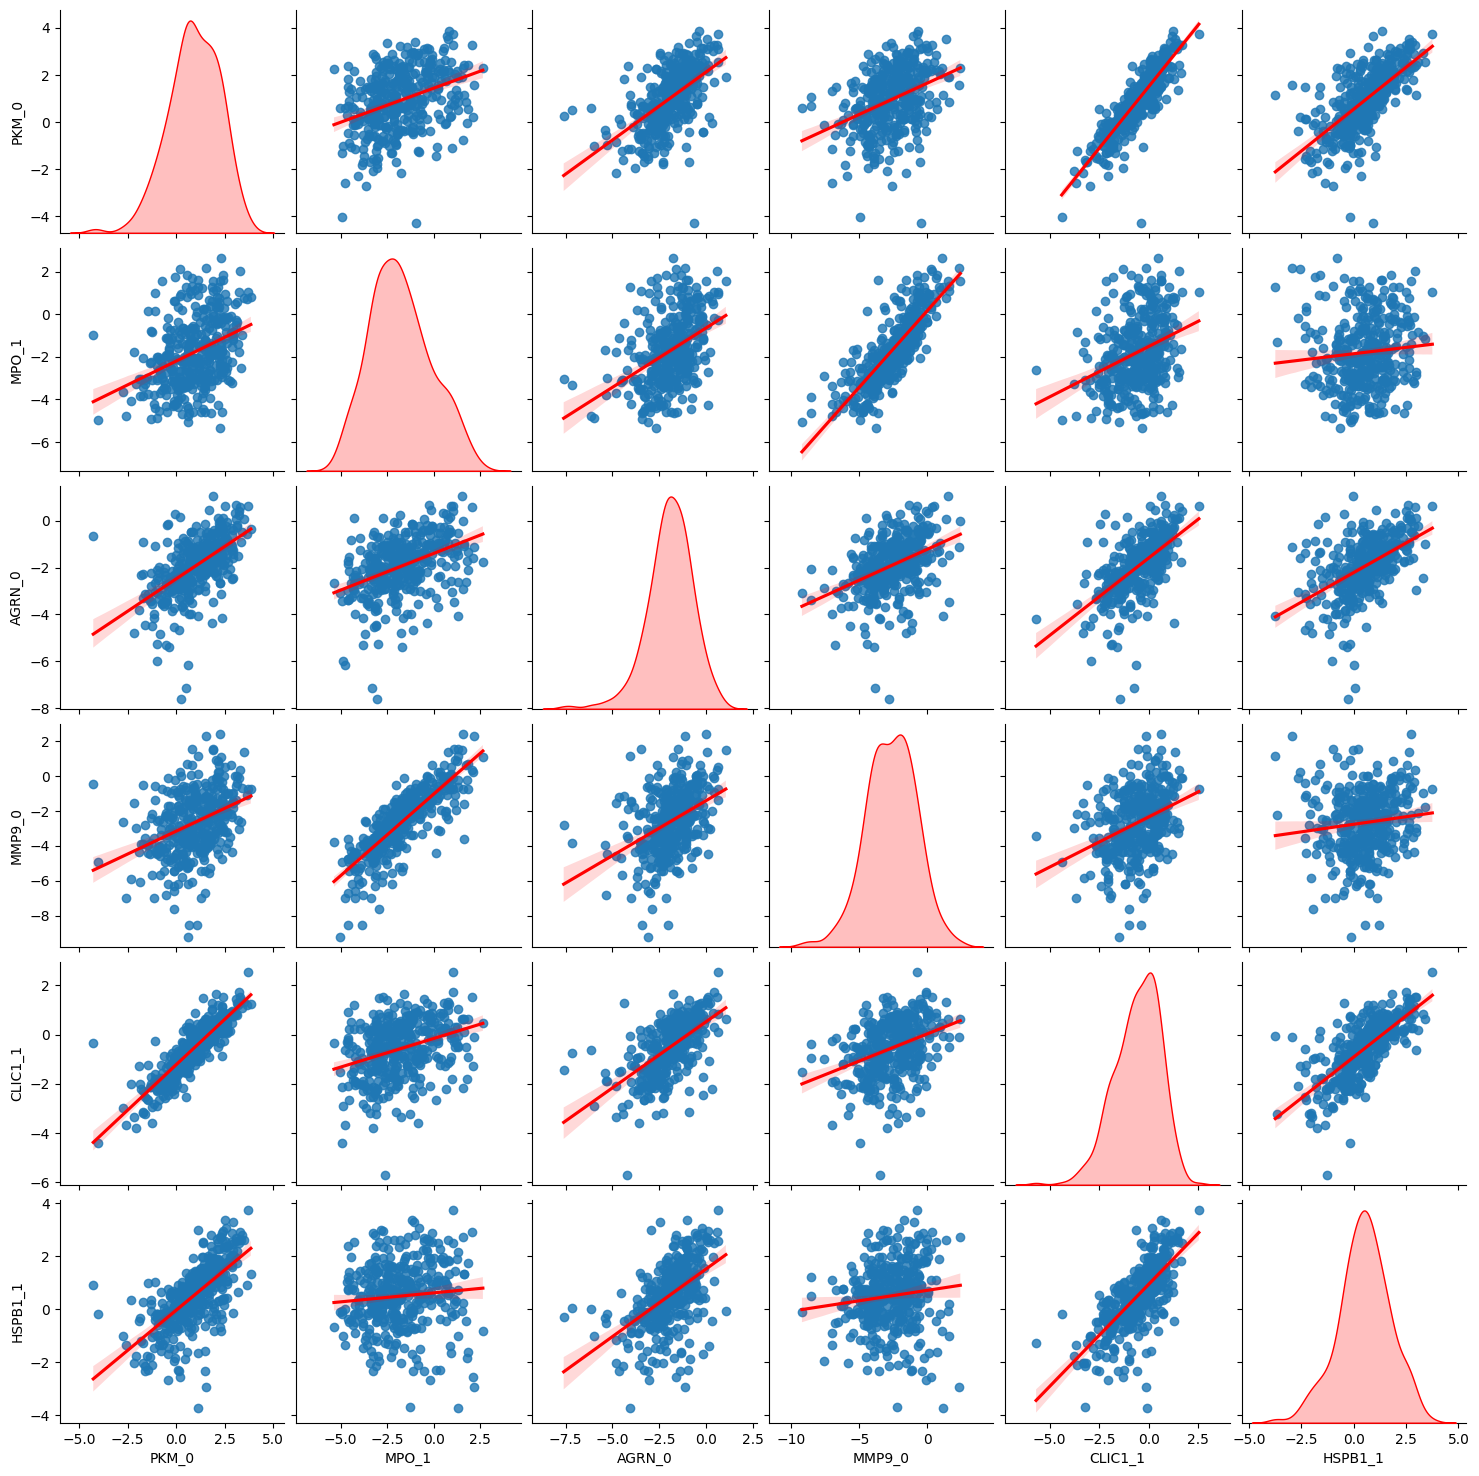

In [36]:
sns.pairplot(df_400[MMK_BIOMARKERS].apply(np.log), 
             kind='reg', 
             diag_kind='kde', 
             diag_kws={'color':'red'}, 
             plot_kws={'line_kws':{'color':'red'}})
plt.show()

## Combinations of biomarkers

We observe that biomarkers combinations that improve the performance are those that include oposite trends classifying by Condition.

<Axes: xlabel='LDHA_0', ylabel='Count'>

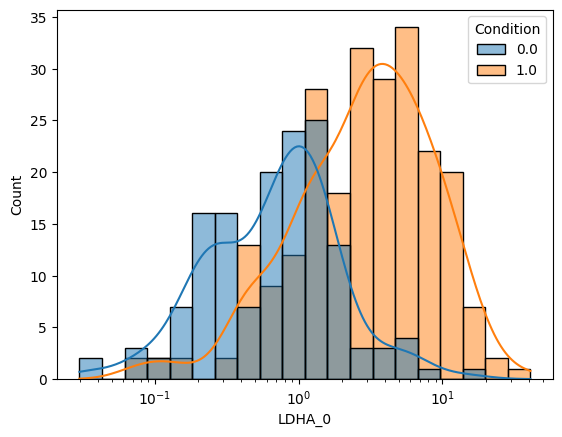

In [38]:
sns.histplot(data=df_400, x="LDHA_0", hue="Condition", bins=20, kde=True, log_scale=True)

<Axes: xlabel='DCN_0', ylabel='Count'>

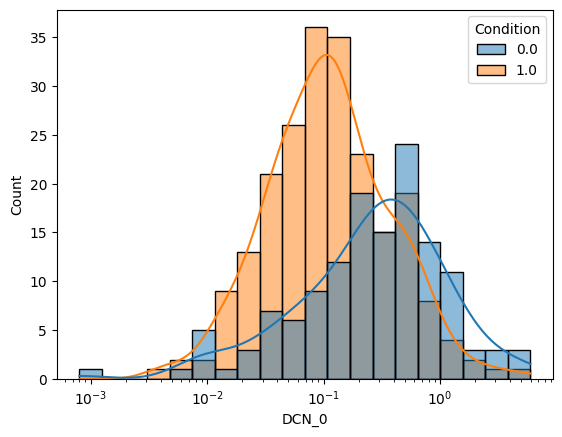

In [39]:
sns.histplot(data=df_400, x="DCN_0", hue="Condition", bins=20, kde=True, log_scale=True)